In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from prophet import Prophet
import xgboost as xgb
import catboost as cb

In [2]:
BASE_DIR = '../../Data/S_Data'
geolocation_path = os.path.join(BASE_DIR, 'geolocation.csv')
order_items_path = os.path.join(BASE_DIR, 'order_items.csv')
order_payments_path = os.path.join(BASE_DIR, 'order_payments.csv')
order_reviews_path = os.path.join(BASE_DIR, 'order_reviews.csv')
orders_path = os.path.join(BASE_DIR, 'orders.csv')
products_path = os.path.join(BASE_DIR, 'products.csv')
sellers_path = os.path.join(BASE_DIR, 'sellers.csv')

In [3]:
order_items_df = pd.read_csv(order_items_path) # ../../Data/S_Data/order_items.csv
orders_df = pd.read_csv(orders_path)

------------------------------------------------------

In [4]:
merged_df = pd.merge(order_items_df, orders_df, how='left', on='order_id')

merged_df = merged_df.set_index('order_purchase_timestamp')
merged_df.index = pd.to_datetime(merged_df.index)
merged_df.index.name = 'date'
merged_df['items'] = merged_df.groupby('order_id')['order_item_id'].transform('count')
merged_df.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,items
date,,,,,,,,,,,,,,
2017-09-13 08:59:02,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1
2017-04-26 10:53:06,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,1


<Axes: xlabel='date'>

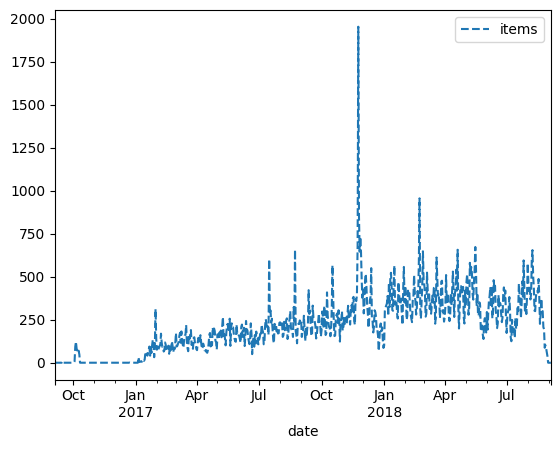

In [5]:
weekly_items_df = merged_df.resample('D').sum()[['items']]
weekly_items_df.plot(style='--')

<Axes: xlabel='date'>

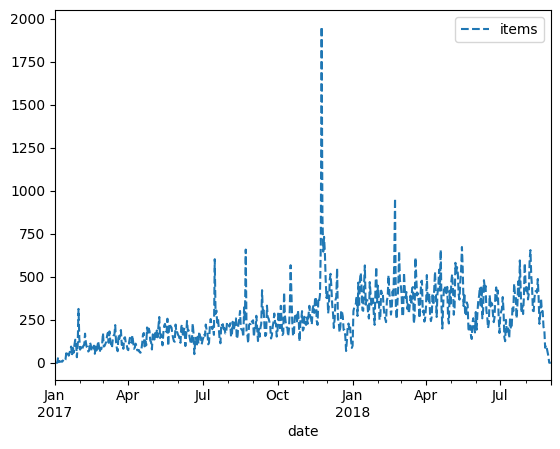

In [6]:
weekly_items_df = weekly_items_df.loc[weekly_items_df.index >= '2017-01-01']
weekly_items_df = weekly_items_df.loc[weekly_items_df.index <= '2018-09-01']
weekly_items_df = weekly_items_df.query('items < 4000').copy()
weekly_items_df.plot(style='--')

<Axes: ylabel='Frequency'>

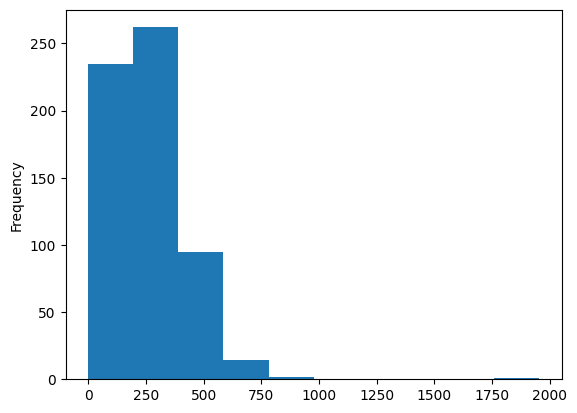

In [7]:
weekly_items_df['items'].plot(kind='hist')

In [8]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

weekly_items_df = create_features(weekly_items_df)
weekly_items_df

,items,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,
2017-01-01,0,0,6,1,1,2017,1,1,52
2017-01-02,0,0,0,1,1,2017,2,2,1
2017-01-03,0,0,1,1,1,2017,3,3,1
2017-01-04,0,0,2,1,1,2017,4,4,1
2017-01-05,32,0,3,1,1,2017,5,5,1
...,...,...,...,...,...,...,...,...,...
2018-08-28,63,0,1,3,8,2018,240,28,35
2018-08-29,38,0,2,3,8,2018,241,29,35
2018-08-30,0,0,3,3,8,2018,242,30,35


In [9]:
def add_lags(df):
    target_map = df['items'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('4W')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('8W')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('12W')).map(target_map)
    return df

weekly_items_df = add_lags(weekly_items_df)
weekly_items_df.tail()

,items,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
date,,,,,,,,,,,,
2018-08-28,63,0,1,3,8,2018,240,28,35,579.0,311.0,388.0
2018-08-29,38,0,2,3,8,2018,241,29,35,461.0,382.0,439.0
2018-08-30,0,0,3,3,8,2018,242,30,35,416.0,305.0,321.0
2018-08-31,0,0,4,3,8,2018,243,31,35,447.0,148.0,446.0
2018-09-01,0,0,5,3,9,2018,244,1,35,368.0,125.0,258.0


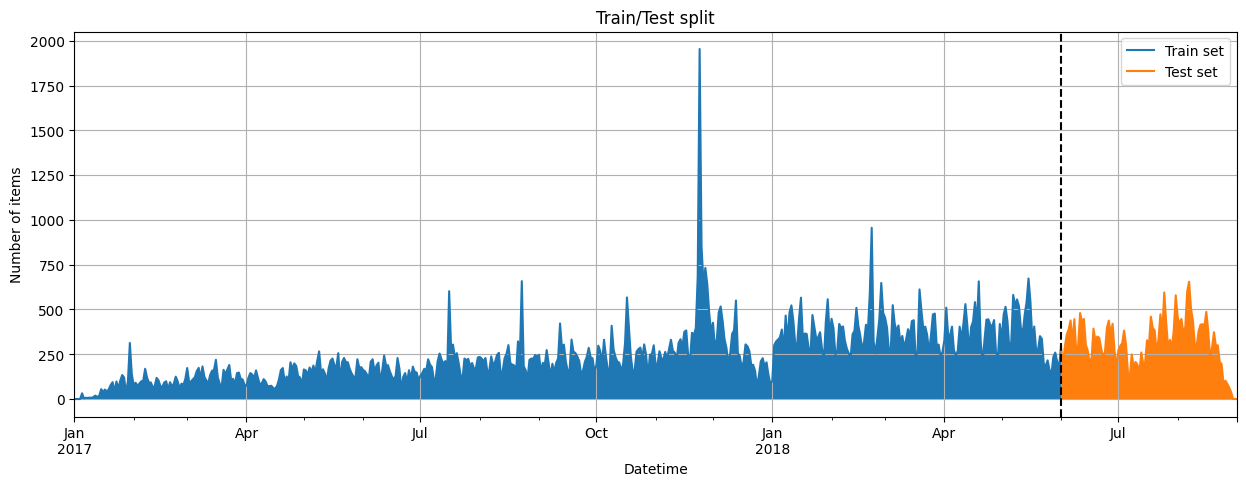

In [10]:
fig, ax = plt.subplots(sharex=True, figsize=(15, 5))
train = weekly_items_df.loc[weekly_items_df.index <= '2018-06-01']
test = weekly_items_df.loc[weekly_items_df.index >= '2018-06-01']
train['items'].plot(ax=ax)
test['items'].plot(ax=ax)
ax.fill_between(train.index, train['items'])
ax.fill_between(test.index, test['items'])
ax.axvline('2018-06-01', ls='--', color='black')
plt.legend(['Train set', 'Test set'])
plt.title('Train/Test split')
plt.ylabel('Number of items')
plt.xlabel('Datetime')
plt.grid(True)
plt.show()

In [11]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3']
TARGET = 'items'

X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

In [12]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       max_depth=3,
                       learning_rate=0.01, 
                       eval_metric='rmse')

reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:292.98468	validation_1-rmse:338.28975
[100]	validation_0-rmse:146.41610	validation_1-rmse:176.08483
[200]	validation_0-rmse:100.62807	validation_1-rmse:134.38666
[300]	validation_0-rmse:79.70097	validation_1-rmse:131.32615
[400]	validation_0-rmse:72.52979	validation_1-rmse:127.44192
[500]	validation_0-rmse:66.36730	validation_1-rmse:127.27093
[600]	validation_0-rmse:62.24312	validation_1-rmse:126.84690
[665]	validation_0-rmse:60.15983	validation_1-rmse:127.09192


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
y_pred = reg.predict(X_test)
y_pred = pd.Series(y_pred)
df = pd.DataFrame(y_test.values, columns=['True Values'])
df['Predicted XGBoost'] = y_pred.values
df.index = y_test.index

Text(0, 0.5, 'Number of items')

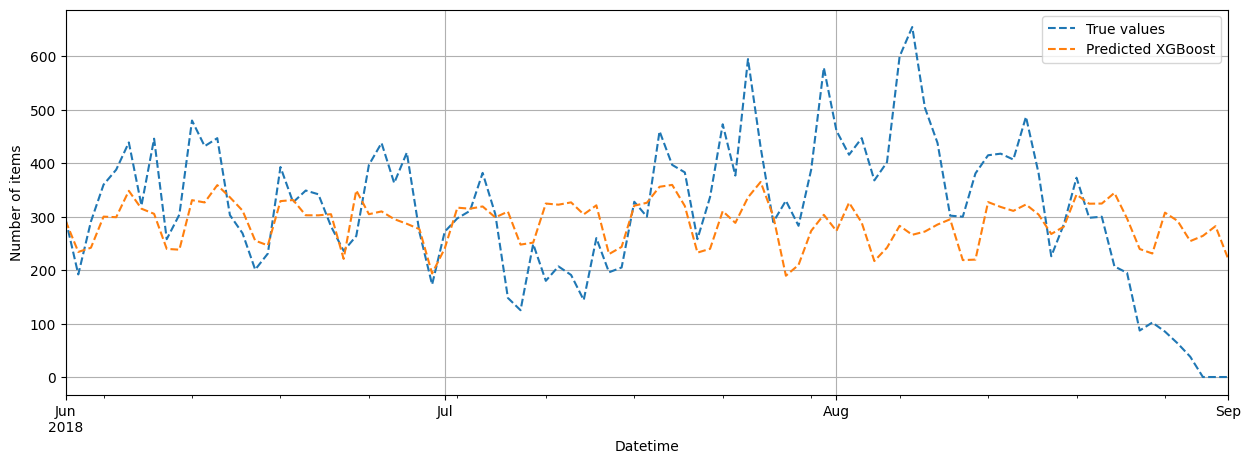

In [14]:
fig, ax = plt.subplots(sharex=True, figsize=(15,5))
df['True Values'].plot(ax=ax, style='--')
df['Predicted XGBoost'].plot(ax=ax, style='--')
plt.legend(['True values', 'Predicted XGBoost'])
plt.grid(True)
plt.xlabel('Datetime')
plt.ylabel('Number of items')

In [15]:
reg2 = cb.CatBoostRegressor(
    n_estimators=1000,
    early_stopping_rounds=50,
    loss_function='RMSE',
    max_depth=3,
    verbose=100,
    learning_rate=0.01
)

reg2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 162.1775766	test: 162.1775766	test1: 148.0939185	best: 148.0939185 (0)	total: 47.8ms	remaining: 47.8s
100:	learn: 126.3066264	test: 126.3066264	test1: 131.2141105	best: 131.2141105 (100)	total: 69.5ms	remaining: 619ms
200:	learn: 112.0627704	test: 112.0627704	test1: 129.1512266	best: 129.1512266 (200)	total: 89.8ms	remaining: 357ms
300:	learn: 103.3268804	test: 103.3268804	test1: 127.7122892	best: 127.7122892 (300)	total: 110ms	remaining: 255ms
400:	learn: 96.5760249	test: 96.5760249	test1: 126.3480567	best: 126.3479884 (399)	total: 131ms	remaining: 196ms
500:	learn: 91.7564511	test: 91.7564511	test1: 125.5014161	best: 125.5014161 (500)	total: 153ms	remaining: 153ms
600:	learn: 87.9378138	test: 87.9378138	test1: 125.1553093	best: 125.0759645 (580)	total: 175ms	remaining: 116ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 124.874774
bestIteration = 631

Shrink model to first 632 iterations.


In [16]:
y_pred2 = reg2.predict(X_test)
y_pred2 = pd.Series(y_pred2)
df['Predicted Catboost'] = y_pred2.values

Text(0, 0.5, 'Number of items')

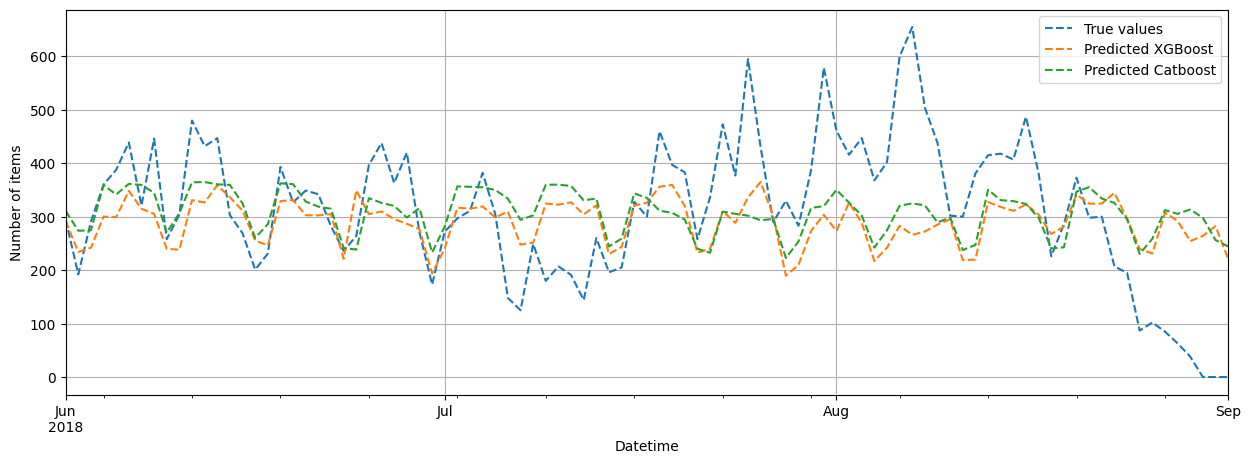

In [17]:
fig, ax = plt.subplots(sharex=True, figsize=(15,5))
df['True Values'].plot(ax=ax, style='--')
df['Predicted XGBoost'].plot(ax=ax, style='--')
df['Predicted Catboost'].plot(ax=ax, style='--')
plt.legend(['True values', 'Predicted XGBoost', 'Predicted Catboost'])
plt.grid(True)
plt.xlabel('Datetime')
plt.ylabel('Number of items')

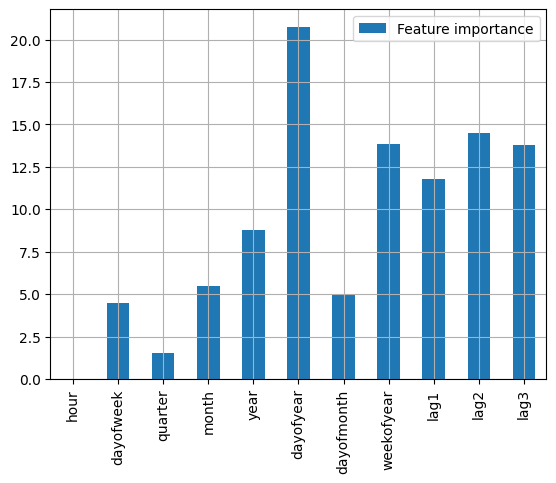

In [18]:
feature_importance_df = pd.DataFrame(reg2.get_feature_importance(), columns=['Feature importance'])
feature_importance_df.index = FEATURES
feature_importance_df.plot.bar()
plt.grid(True)

In [19]:
weekly_items_df.index.max()

Timestamp('2018-09-01 00:00:00')

In [20]:
future = pd.date_range('2018-08-26', '2018-09-10', freq='D')
future_df = pd.DataFrame(index=future)

In [21]:
future_df['isFuture'] = True
weekly_items_df['isFuture'] = False
df_and_future = pd.concat([weekly_items_df, future_df])

In [22]:
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
df_and_future.tail()

,items,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-09-06,NaN,0,3,3,9,2018,249,6,36,438.0,144.0,303.0,True
2018-09-07,NaN,0,4,3,9,2018,250,7,36,302.0,260.0,269.0,True
2018-09-08,NaN,0,5,3,9,2018,251,8,36,300.0,196.0,201.0,True
2018-09-09,NaN,0,6,3,9,2018,252,9,36,381.0,205.0,231.0,True
2018-09-10,NaN,0,0,3,9,2018,253,10,37,415.0,328.0,393.0,True


In [23]:
future_w_features = df_and_future.query('isFuture').copy()

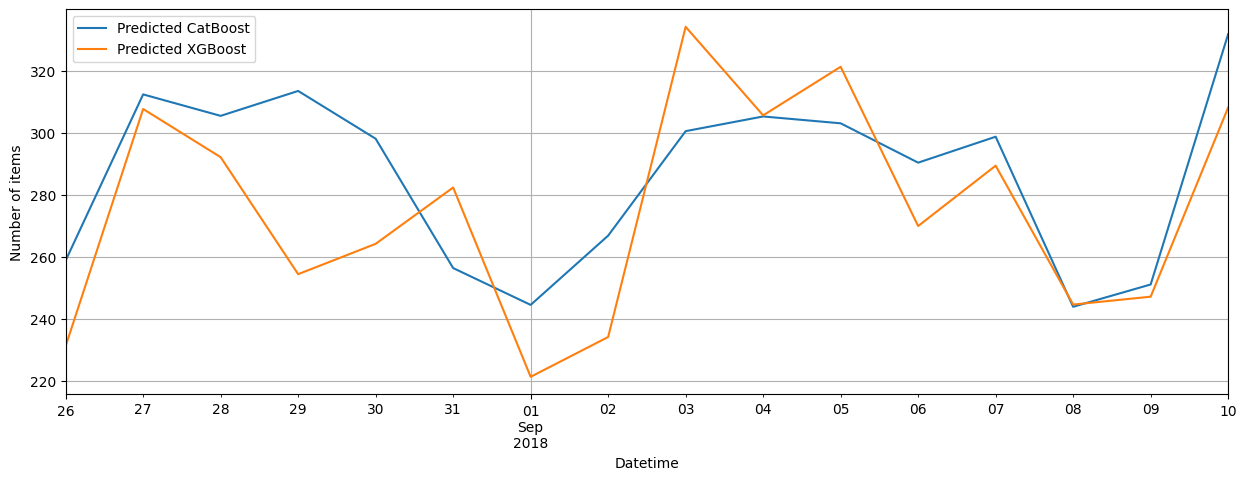

In [24]:
future_w_features['pred_xgboost'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred_catboost'] = reg2.predict(future_w_features[FEATURES])
fig, ax = plt.subplots(figsize=(15,5))
future_w_features['pred_catboost'].plot(ax=ax)
future_w_features['pred_xgboost'].plot(ax=ax)
plt.grid(True)
plt.xlabel('Datetime')
plt.ylabel('Number of items')
plt.legend(['Predicted CatBoost', 'Predicted XGBoost'])

In [25]:
prophet_df = pd.DataFrame(y_train.index.values, columns=['ds'])
prophet_df['y'] = y_train.values
reg3 = Prophet()
reg3.fit(prophet_df)

20:22:04 - cmdstanpy - INFO - Chain [1] start processing
20:22:04 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
prophet_test = X_test.copy()
prophet_test['ds'] = prophet_test.index
y_pred3 = reg3.predict(prophet_test)

Text(0, 0.5, 'Number of items')

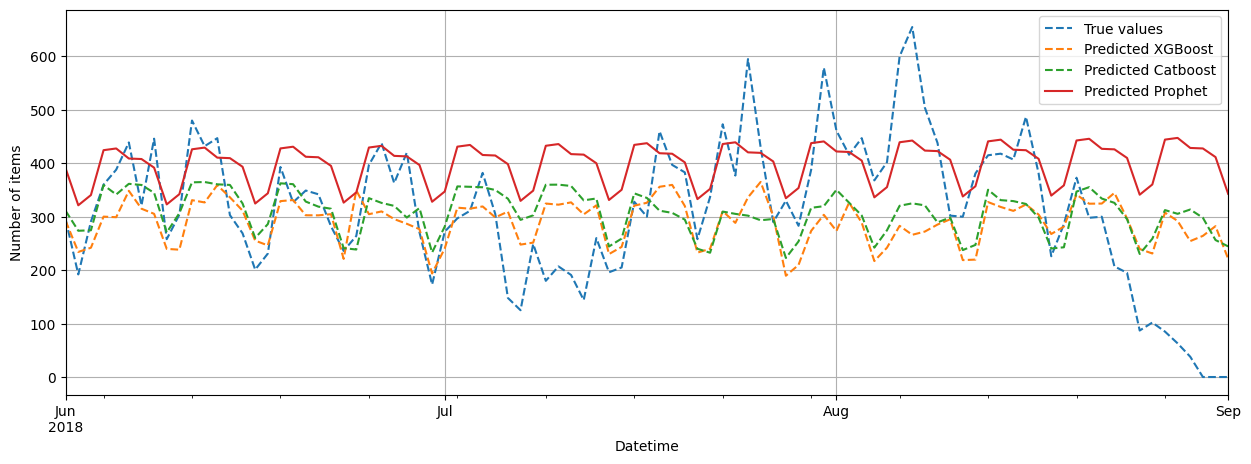

In [27]:

fig, ax = plt.subplots(sharex=True, figsize=(15,5))
df['True Values'].plot(ax=ax, style='--')
df['Predicted XGBoost'].plot(ax=ax, style='--')
df['Predicted Catboost'].plot(ax=ax, style='--')
plt.plot(y_pred3['ds'], y_pred3['yhat'])
plt.legend(['True values', 'Predicted XGBoost', 'Predicted Catboost', 'Predicted Prophet'])
plt.grid(True)
plt.xlabel('Datetime')
plt.ylabel('Number of items')

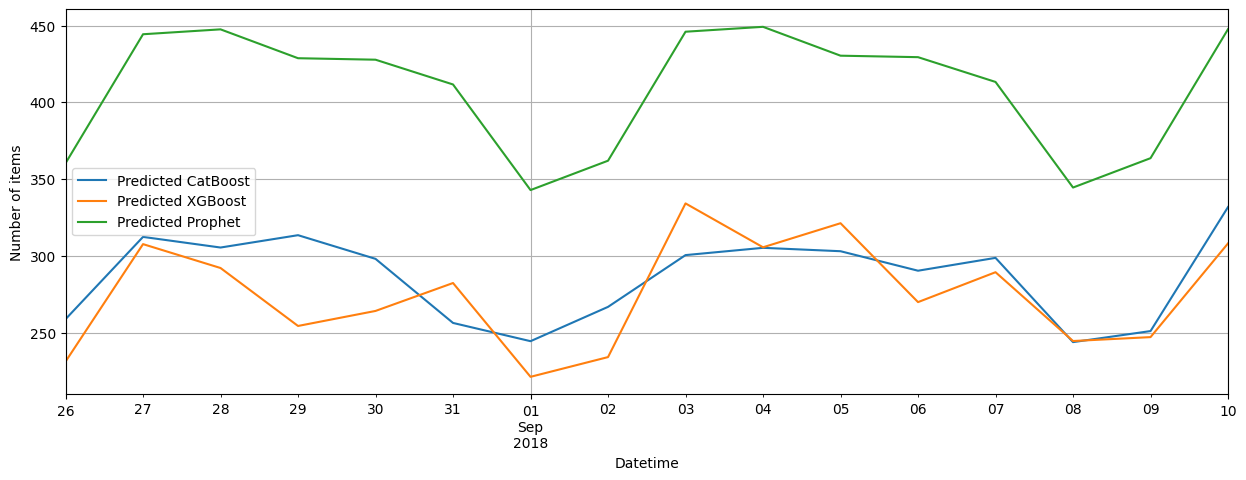

In [28]:

future_w_features['pred_xgboost'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred_catboost'] = reg2.predict(future_w_features[FEATURES])

future_w_features['ds'] = future_w_features.index
fut_pred = reg3.predict(future_w_features)
future_w_features['pred_prophet'] = fut_pred['yhat'].values

fig, ax = plt.subplots(figsize=(15,5))
future_w_features['pred_catboost'].plot(ax=ax)
future_w_features['pred_xgboost'].plot(ax=ax)
future_w_features['pred_prophet'].plot(ax=ax)
plt.grid(True)
plt.xlabel('Datetime')
plt.ylabel('Number of items')
plt.legend(['Predicted CatBoost', 'Predicted XGBoost', 'Predicted Prophet'])

In [29]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

df_cv = cross_validation(reg3, horizon = '14 days')

df_p = performance_metrics(df_cv)
df_p.head()

  0%|          | 0/66 [00:00<?, ?it/s]

20:22:05 - cmdstanpy - INFO - Chain [1] start processing
20:22:05 - cmdstanpy - INFO - Chain [1] done processing
20:22:05 - cmdstanpy - INFO - Chain [1] start processing
20:22:05 - cmdstanpy - INFO - Chain [1] done processing
20:22:06 - cmdstanpy - INFO - Chain [1] start processing
20:22:06 - cmdstanpy - INFO - Chain [1] done processing
20:22:06 - cmdstanpy - INFO - Chain [1] start processing
20:22:06 - cmdstanpy - INFO - Chain [1] done processing
20:22:06 - cmdstanpy - INFO - Chain [1] start processing
20:22:06 - cmdstanpy - INFO - Chain [1] done processing
20:22:06 - cmdstanpy - INFO - Chain [1] start processing
20:22:06 - cmdstanpy - INFO - Chain [1] done processing
20:22:06 - cmdstanpy - INFO - Chain [1] start processing
20:22:06 - cmdstanpy - INFO - Chain [1] done processing
20:22:06 - cmdstanpy - INFO - Chain [1] start processing
20:22:07 - cmdstanpy - INFO - Chain [1] done processing
20:22:07 - cmdstanpy - INFO - Chain [1] start processing
20:22:07 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,10077.623429,100.387367,65.803815,0.396661,0.291307,0.296663,0.809618
1,3 days,8728.053615,93.424053,62.921598,0.316622,0.176959,0.241011,0.785573
2,4 days,8360.400770,91.435227,63.093383,0.232548,0.171832,0.208082,0.772727
3,5 days,8654.728506,93.030793,62.841585,0.253077,0.158392,0.218163,0.794466
4,6 days,12795.614374,113.117701,70.108949,0.276732,0.156453,0.235975,0.737813


In [30]:
from sklearn.metrics import root_mean_squared_error

print('XGBoost model RMSE score: {0:0.4f}'. format(root_mean_squared_error(y_test, y_pred)))
print('CatBoost model RMSE score: {0:0.4f}'. format(root_mean_squared_error(y_test, y_pred2)))
print('Prophet model RMSE score: {0:0.4f}'. format(root_mean_squared_error(y_test, y_pred3['yhat'])))

XGBoost model RMSE score: 126.7989
CatBoost model RMSE score: 124.8748
Prophet model RMSE score: 149.2900
